# Spotify and GoEmotions - The Baseline Model using Zero-Shot Learning


## Setup

### Install the TensorFlow Model Garden pip package

`tf-nightly` is the nightly Model Garden package created daily automatically. We install it with pip.

In [ ]:
!pip install --upgrade pip
!pip install tensorflow
!pip install tfds-nightly

     |████████████████████████████████| 2.1 MB 27.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 KB 10.6 MB/s eta 0:00:00


### Install the Sequence Projection Models package

Install Bazel: This will allow us to build custom TensorFlow ops used by the PRADO architecture.

In [ ]:
!sudo apt install curl gnupg
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list
!sudo apt update
!sudo apt install bazel

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
gnupg is already the newest version (2.2.4-1ubuntu1.4).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3199  100  3199    0     0  10454      0 --:--:-- --:--:-- --:--:-- 10488
OK
deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8
Get:1 https://storage.googleapis.com/bazel-apt stable InRelease [2,256 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 https://storage.googleapis.com/bazel-apt stable/jdk1.8 amd64 Packages [7,148 B]
Ign:5 https://developer.download.nvidia.com/

Install the library:
* `seq_flow_lite` includes the PRADO architecture and custom ops.
* We download the code from GitHub, and then build and install the TF and TFLite ops used by the model.


In [ ]:
#only run if you're rerunning cells below
!rm -rf tensorflow/models
!rm -rf models

In [ ]:
!git clone https://www.github.com/tensorflow/models
!models/research/seq_flow_lite/demo/colab/setup_workspace.sh
!pip install models/research/seq_flow_lite
!rm -rf models/research/seq_flow_lite/tf_ops
!rm -rf models/research/seq_flow_lite/tflite_ops

Cloning into 'models'...
remote: Enumerating objects: 71720, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 71720 (delta 2), reused 4 (delta 1), pack-reused 71710
Receiving objects: 100% (71720/71720), 578.87 MiB | 34.82 MiB/s, done.
Resolving deltas: 100% (50726/50726), done.
Processing ./models/research/seq_flow_lite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for seq-flow-lite: filename=seq_flow_lite-0.1-py3-none-any.whl size=772854 sha256=32fc8ff9eaf9fe9a62b85fd77be7fe2efcc85963a0dcc5dfee5f5bf02d2811a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-gw38

## Training an Emotion Prediction Model

* First, we load the GoEmotions data from TFDS and load in the Spotify data.
* Next, we prepare the PRADO model. We set up the model configuration, including hyperparameters and labels. We also prepare the dataset, which involves projecting the inputs from the dataset, and passing the projections to the model.  This is needed because a model training on TPU can not handle string inputs.
* Then, we load in the original GoEmotion model saved previously from checkpoints.
* Lastly, we predict on the Spotify test set and analyze the results 

***Start here on Runtime reset***, once the packages above are properly installed:
* Go to the `seq_flow_lite` directory.

In [ ]:
%cd models/research/seq_flow_lite

/content/models/research/seq_flow_lite


* Import the Tensorflow and Tensorflow Dataset libraries.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import pandas as pd
import io

### The data: GoEmotions and Spoitfy
GoEmotions is a corpus of comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral.

*   Number of labels: 27.
*   Size of training dataset: 43,410.
*   Size of evaluation dataset: 5,427.
*   Maximum sequence length in training and evaluation datasets: 30.

The Spotify data is being loaded in from a CSV stored on Google Drive. It contains our tagged sentences.


Load the data from TFDS:

In [ ]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

In [ ]:
#only run this if loading in the goemotions data
ds = tfds.load('goemotions', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43410 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteJSHJBD/goemotions-train.tfrecord*...:   0%|        …

Generating validation examples...:   0%|          | 0/5426 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteJSHJBD/goemotions-validation.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/5427 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incompleteJSHJBD/goemotions-test.tfrecord*...:   0%|         …

Dataset goemotions downloaded and prepared to ~/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [ ]:
assert isinstance(ds, tf.data.Dataset)

In [ ]:
print(ds)

<PrefetchDataset element_spec={'admiration': TensorSpec(shape=(), dtype=tf.bool, name=None), 'amusement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'anger': TensorSpec(shape=(), dtype=tf.bool, name=None), 'annoyance': TensorSpec(shape=(), dtype=tf.bool, name=None), 'approval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'caring': TensorSpec(shape=(), dtype=tf.bool, name=None), 'comment_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'confusion': TensorSpec(shape=(), dtype=tf.bool, name=None), 'curiosity': TensorSpec(shape=(), dtype=tf.bool, name=None), 'desire': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disappointment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disapproval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disgust': TensorSpec(shape=(), dtype=tf.bool, name=None), 'embarrassment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'excitement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'fear': TensorSpec(shape=(), dtype=tf.bool, name=

Load in Spotify data for later use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sp_tr = pd.read_csv('/content/drive/MyDrive/266/strat_training.csv')
sp_test = pd.read_csv('/content/drive/MyDrive/266/strat_test.csv')
sp_dev = pd.read_csv('/content/drive/MyDrive/266/strat_val.csv')

In [ ]:
sp_train_new = sp_tr.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)
sp_test_new = sp_test.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)
sp_dev_new = sp_dev.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)

In [ ]:
sp_train_new = sp_train_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
sp_test_new = sp_test_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
sp_dev_new = sp_dev_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})

In [ ]:
for label in LABELS:
  sp_train_new[label] = sp_train_new[label].astype('bool')
  sp_test_new[label] = sp_test_new[label].astype('bool')
  sp_dev_new[label] = sp_dev_new[label].astype('bool')

In [ ]:
print(len(sp_train_new.index), len(sp_test_new.index), len(sp_dev_new.index))

1604 193 201


In [ ]:
#sp_train = tf.data.Dataset.from_tensor_slices((sp_train_new['target_string'].values, sp_train_new.drop('target_string', axis=1).values))
#sp_test = tf.data.Dataset.from_tensor_slices((sp_test_new['target_string'].values, sp_test_new.drop('target_string', axis=1).values))
sp_train = tf.data.Dataset.from_tensor_slices(dict(sp_train_new))
sp_test = tf.data.Dataset.from_tensor_slices(dict(sp_test_new))
sp_dev = tf.data.Dataset.from_tensor_slices(dict(sp_dev_new))

In [ ]:
assert isinstance(sp_train, tf.data.Dataset)
assert isinstance(sp_test, tf.data.Dataset)
assert isinstance(sp_dev, tf.data.Dataset)

### The model: PRADO

We train an Emotion Prediction model, based on the [PRADO architecture](https://github.com/tensorflow/models/blob/master/research/seq_flow_lite/models/prado.py) from the [Sequence Projection Models package](https://github.com/tensorflow/models/tree/master/research/seq_flow_lite).

PRADO projects input sequences to fixed sized features. The idea behind this approach is to build embedding-free models that minimize the model size. Instead of using an embedding table to lookup embeddings, sequence projection models compute them on the fly, resulting in space-efficient models.

In this section, we prepare the PRADO model for training.

This GoEmotions dataset is not set up so that it can be directly fed into the PRADO model, so below, we also handle the necessary preprocessing by providing a dataset builder.

Prepare the model configuration:
* Enumerate the labels expected to be found in the GoEmotions dataset.
* Prepare the `MODEL_CONFIG` dictionary which includes training parameters for the model. See sample configs for the PRADO model [here](https://github.com/tensorflow/models/tree/master/research/seq_flow_lite/configs).

In [ ]:
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 1024,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

# Limits the amount of logging output produced by the training run, in order to
# avoid browser slowdowns.
CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 128,
    'max_seq_len_inference': 128,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

### Write a function that builds the datasets for the model.  It will load the data, handle batching, and generate projections for the input text.

## Build dataset from GoEmotion raw

In [ ]:
from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['comment_text']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = tfds.load('goemotions', split=split)
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input,
              num_parallel_calls=tf.data.experimental.AUTOTUNE,
              deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

goemo_train_dataset = build_dataset(base_layers.TRAIN)
goemo_test_dataset = build_dataset(base_layers.EVAL)
goemo_inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

## Build dataset from Spotify raw

In [ ]:
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 100,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 400,
    'max_seq_len_inference': 400,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False, dev = False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['target_string']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features
  if mode == base_layers.TRAIN:
    ds = sp_train
    ds = ds.repeat(count=count)
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  elif mode == base_layers.EVAL and dev == True:
    ds = sp_dev 
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
  elif mode == base_layers.EVAL and dev == False:
    ds = sp_test
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))
  
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL, dev = False)
val_dataset = build_dataset(base_layers.EVAL, dev = True)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

First we define a function to build the model.  We vary the model inputs depending on task.  For training and evaluation, we'll take the projection and sequence length as inputs.  Otherwise, we'll take strings as inputs.

In [ ]:
from models import prado

def build_model(mode):
  # First we define our inputs.
  inputs = []
  if mode == base_layers.TRAIN or mode == base_layers.EVAL:
    # For TRAIN and EVAL, we'll be getting dataset examples,
    # so we'll get projections and sequence_lengths.
    projection = tf.keras.Input(
        shape=(MODEL_CONFIG['max_seq_len'], MODEL_CONFIG['feature_size']),
        name='projection',
        dtype='float32')

    sequence_length = tf.keras.Input(
        shape=(), name='sequence_length', dtype='float32')
    inputs = [projection, sequence_length]
  else:
    # Otherwise, we get string inputs which we need to project.
    input = tf.keras.Input(shape=(), name='input', dtype='string')
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, sequence_length = projection_layer(input)
    inputs = [input]

  # Next we add the model layer.
  model_layer = prado.Encoder(MODEL_CONFIG, mode)
  logits = model_layer(projection, sequence_length)

  # Finally we add an activation layer.
  if MODEL_CONFIG['multilabel']:
    activation = tf.keras.layers.Activation('sigmoid', name='predictions')
  else:
    activation = tf.keras.layers.Activation('softmax', name='predictions')
  predictions = activation(logits)

  model = tf.keras.Model(
      inputs=inputs,
      outputs=[predictions])
  
  return model


## Zero-shot Learning: Run pretrained GoEmotion model on the Spotify Dataset



In [ ]:
original_model = '/content/drive/MyDrive/266/original_model/goemo_model'

In [ ]:
from keras import backend as K
def custom_f1(y_true, y_pred):
  def recall_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall
  def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)
metric = custom_f1
metrics.append(metric)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(original_model)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

1/1 [==============================] - 21s 21s/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.3333 - recall@0.5/admiration: 0.2222 - precision@0.5/amusement: 1.0000 - recall@0.5/amusement: 1.0000 - precision@0.5/anger: 1.0000 - recall@0.5/anger: 1.0000 - precision@0.5/annoyance: 0.0000e+00 - recall@0.5/annoyance: 0.0000e+00 - precision@0.5/approval: 0.0000e+00 - recall@0.5/approval: 0.0000e+00 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 1.0000 - recall@0.5/curiosity: 0.2000 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 1.0000 - recall@0.5/disapproval: 0.0833 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excite

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.3333333432674408, recall@0.5: 0.2222222238779068)
amusement: (precision@0.5: 1.0, recall@0.5: 1.0)
anger: (precision@0.5: 1.0, recall@0.5: 1.0)
annoyance: (precision@0.5: 0.0, recall@0.5: 0.0)
approval: (precision@0.5: 0.0, recall@0.5: 0.0)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.0, recall@0.5: 0.0)
curiosity: (precision@0.5: 1.0, recall@0.5: 0.20000000298023224)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 1.0, recall@0.5: 0.0833333358168602)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 1.0, recall@0.5: 1.0)
grief: (precision@0.5: 0.0, recall@0.5: 0.0)
joy: (precision@0.5: 0.0, recall@0.5: 0.0)
love: (precision@0.5: 1.0, recall@0.5: 1.0)
nervousness: (precision@0.5:

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import *
import sys
from pylab import *
import seaborn as sns

In [ ]:
to_pred = list(sp_test_new['target_string'])

In [ ]:
for label in LABELS:
  sp_test_new[label] = sp_test_new[label].astype('int')
sp_test_pred_all = sp_test_new.drop(['target_string'], axis = 1).to_numpy()
sp_test_pred_max = tf.argmax(sp_test_pred_all, axis = 1)

In [ ]:
print(sp_test_pred_max)

tf.Tensor(
[27  4 14 10 27  0 22 27  0  0 26 27 21  0 27  7 15 15  4 27  7 27 27 22
  7 14  4 21 27 25 27  9 27 14 27 26 27  7  9  4 21 27 27 14  2 27 27  4
  7 27 15 22 27  2  3  0  4 10  7 27 27 17  4 10 27 27 27  7  3 27  4  7
  0  6 27  4 14  9 10 27 25 27  5 20 27  9 22 10  7 27  6 22 27 20 27  4
 27 20  0 27  4 27 27 10  8 27 14 13 27 27 21  0 16 11 13 10  4  4  6  0
 27  9  0  9 27  0 27 27 10  0 27 27 18 21  5 27  7  7 27 10 27 20 10 20
  2  4  7 27 10  8  9  0 27 19  4  0  0  9  7 27 27  4  9 19 27 20 27  4
  6 22  7 15 27  6  3 22 15 17 27  0 20  6  0 27 13  4  7 15  4 16 27  4
 14  7 27 22 27  6 27  9  0  4  9  7 27 13  5 27  4 21 27  6 10 27 21  7
 27  6  0 27  7 10 22 27  0 27 27 27  0 10 27  9 27 20  2 10 10 27 27 22
  6 10 21  4  0 27  9  0 27 27 20 20  0  6 27 27 24 27  6 23 27 13 10  2
 27 27 22 10  9 27 27 17 27 10  0  7  8 10 15  6  4  4 27 27  4], shape=(285,), dtype=int64)


In [ ]:
model = build_model(base_layers.PREDICT)

model.load_weights(original_model)

preds =model.predict(x=to_pred, verbose=1)

9/9 [==============================] - 0s 6ms/step


In [ ]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor(
[27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 15 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 20 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27  7 27 27 27 27 27 27 27 27 20 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 18 27 27 27 27 27  0 27 27
 27 27 27 27 27 27 27 27 27 27 27 27  0 27 27 27 27 27 27 27 27  4 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27  7 27 27 27 15 17 27 27  4 27 27 27 27 27 27 15 27 27 27  1
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 18 27 27 27  0 27 27 27 27 27 27 27 27  7 27 27
 27 27  4 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27
 27 27 27 27 27 27 27 27 27 27 27 27 27 27 15 27 27 27 27 27 27], shape=(285,), dtype=int64)


In [ ]:
con_mat = tf.math.confusion_matrix(labels=sp_test_pred_max, predictions=preds).numpy()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = LABELS, 
                     columns = LABELS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


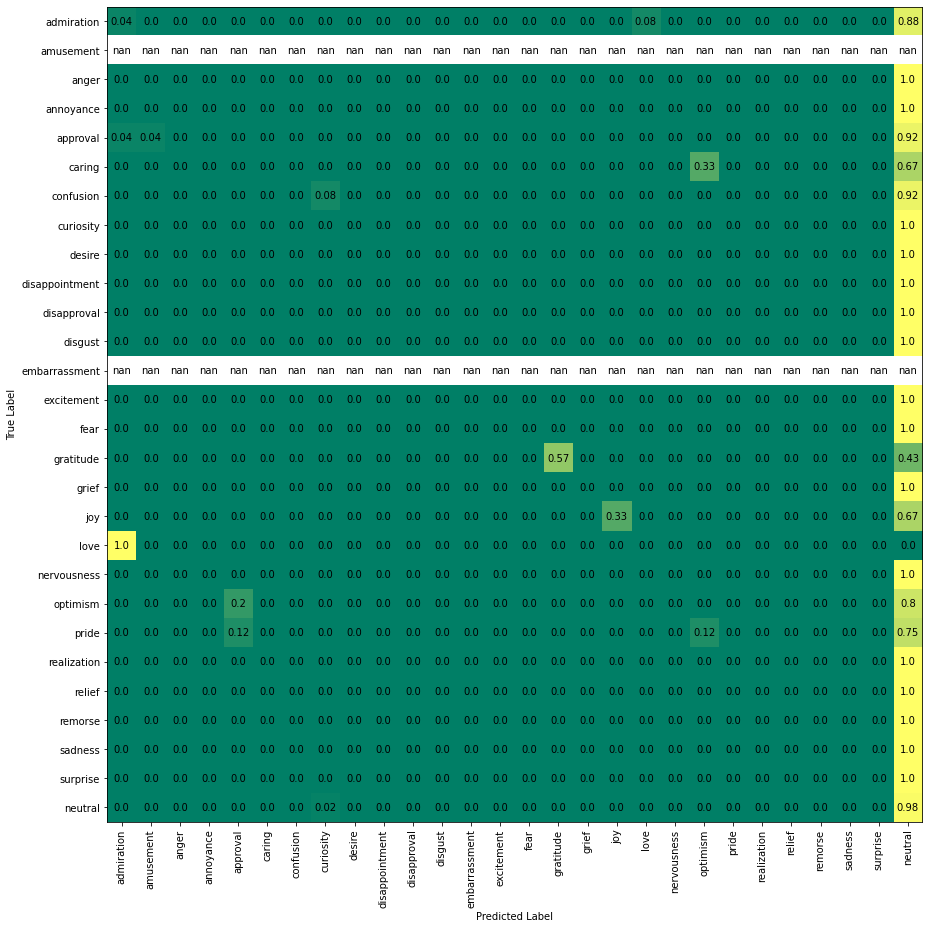

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(con_mat_df, cmap = 'summer')

for (j,i),label in np.ndenumerate(con_mat_df):
    plt.text(i,j,label,ha='center',va='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks = list(range(0,28)), labels = LABELS, rotation = 90);
plt.yticks(ticks = list(range(0,28)), labels = LABELS);

Get accuracy of baseline model

In [ ]:
correct = 0
neut_count = 0
for i in range(0,len(preds)):
  if preds[i] ==  sp_test_pred_max[i]:
    correct += 1
  if sp_test_pred_max[i] == 27:
    neut_count += 1
print("the accuracy of the model is ", correct/len(preds))
print("Number of neutrals in test set:", neut_count)
print("Number of predictions:", len(preds))

the accuracy of the model is  0.3263157894736842
Number of neutrals in test set: 89
Number of predictions: 285


Some predictions

In [ ]:
PREDICT_TEXT = [
  b'Good for you!',
  b'Happy birthday!',
  b'I love you.',
]

In [ ]:
model = build_model(base_layers.PREDICT)
model.load_weights(original_model)

for text in PREDICT_TEXT:
  results = model.predict(x=[text])
  print('')
  print('{}:'.format(text))
  labels = np.flip(np.argsort(results[0]))
  for x in range(3):
    label = LABELS[labels[x]]
    print('{}: {}'.format(label, results[0][labels[x]]))